In [2]:
import sys
sys.path.append('/home/jovyan/workspace')

In [ ]:
#     if return_dict:
#         outDict = {
#             'var': var,
#             'varType': varType,
#             'mesh': mesh,
#             'substrate': substrate,
#             'dType': dType,
#             'varDim': varDim
#             }
#         return outDict

## Development

In [3]:
import numpy as np
import underworld as uw
from underworld import function as fn
import math
import time
import tarfile
import os
import shutil
import json
import itertools
import inspect
import importlib
import csv

# from . import utilities
# from .standards import standardise
# from .utilities import message
# from .utilities import unpack_var

from planetengine import utilities
from planetengine import standardise
from planetengine import message
from planetengine import initials
from planetengine import unpack_var
from planetengine import mapping

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nProcs = comm.Get_size()

In [67]:
ignoreVal = 0.4431257522991823

def _return(outVar, opTag, opTags, updateFunc, updateFuncs):
    if opTags is None:
        opTags = ''
    opTags += opTag
    if updateFuncs is None:
        updateFuncs = []
    updateFuncs.append(updateFunc)
    return outVar, opTags, updateFuncs

def operations(operation, var, opTags = None, updateFuncs = None):

    opDict = {
        'abs': fn.math.abs,
        'cosh': fn.math.cosh,
        'acosh': fn.math.acosh,
        'tan': fn.math.tan,
        'asin': fn.math.asin,
        'log': fn.math.log,
        'atanh': fn.math.atanh,
        'sqrt': fn.math.sqrt,
        'abs': fn.math.abs,
        'log10': fn.math.log10,
        'sin': fn.math.sin,
        'asinh': fn.math.asinh,
        'log2': fn.math.log2,
        'atan': fn.math.atan,
        'sinh': fn.math.sinh,
        'cos': fn.math.cos,
        'tanh': fn.math.tanh,
        'erf': fn.math.erf,
        'erfc': fn.math.erfc,
        'exp': fn.math.exp,
        'acos': fn.math.acos,
        'dot': fn.math.dot
        }
    # ^^^ not all of these will work yet...
    if not operation in opDict:
        raise Exception

    opFn = opDict[operation]
    outVar = opFn(var)

    opTag = operation + 'Oper'
    updateFunc = lambda: None

    return _return(outVar, opTag, opTags, updateFunc, updateFuncs)

def component(component, var, opTags = None, updateFuncs = None):

    varDict = unpack_var(var, return_dict = True)
    if not varDict['varDim'] == varDict['mesh'].dim:
        # hence is not a vector and so has no components:
        raise Exception
    if component == 'mag':
        outVar = fn.math.sqrt(fn.math.dot(var, var))
    else:
        pemesh = standardise(varDict['mesh'])
        outVar = fn.math.dot(var, pemesh.comps[component])

    opTag = component + 'Comp'
    updateFunc = lambda: None

    return _return(outVar, opTag, opTags, updateFunc, updateFuncs)

def gradient(gradient, var, opTags = None, updateFuncs = None):

    varDict = unpack_var(var, return_dict = True)
    pemesh = standardise(varDict['mesh'])
    projVar, project = pemesh.meshify(
        var,
        return_project = True
        )
    varGrad = projVar.fn_gradient
    if gradient == 'mag':
        outVar = fn.math.sqrt(fn.math.dot(varGrad, varGrad))
    else:
        outVar = fn.math.dot(varGrad, pemesh.comps[gradient])
    project()

    opTag = gradient + 'Grad'
    updateFunc = project

    return _return(outVar, opTag, opTags, updateFunc, updateFuncs)

def bucket(bucket, var, opTags = None, updateFuncs = None):

    if type(bucket) is tuple:
        adjBucket = []
        for val in bucket:
            if type(val) is str:
                if val == 'max':
                    addVal = 1e18
                elif val == 'min':
                    addVal = 1e-18
                else:
                    raise Exception
            else:
                addVal = val
            adjBucket.append(addVal)
        bucketStr = str(bucket[0]) + ':' + str(bucket[1])
    else:
        adjBucket = (bucket - 1e-18, bucket + 1e-18)
        bucketStr = str(bucket)

    outVar = fn.branching.conditional([
        (var < adjBucket[0], 0.),
        (var > adjBucket[1], 0.), # double-open interval - is this a problem?
        (True, 1.),
        ])

    opTag = 'Bucket{' + bucketStr + '}'
    updateFunc = lambda: None

    return _return(outVar, opTag, opTags, updateFunc, updateFuncs)

def quantile(ntiles, nthtile, var, opTags = None, updateFuncs = None):

    if not (type(ntiles) is int and type(nthtile) is int):
        raise Exception

    lowerBound = fn.misc.constant(0.)
    upperBound = fn.misc.constant(0.)

    def update_bounds():
        var_scales = utilities.get_scales(var)
        var_ranges = np.array(
            [maxVal - minVal for minVal, maxVal in var_scales]
            )
        intervalSize = var_ranges / ntiles
        lowerBound.value = var_scales[:,0] + intervalSize * (nthtile - 1)
        upperBound.value = var_scales[:,0] + intervalSize * (nthtile)

    update_bounds()

    l_adj = -1e-18
    if nthtile == ntiles:
        u_adj = -1e-18
    else:
        u_adj = 1e-18
    outVar = fn.branching.conditional([
        (var < lowerBound + l_adj, 0.),
        (var > upperBound + u_adj, 0.),
        (True, var),
        ])

    quantileStr = str(nthtile) + 'of' + str(ntiles)
    opTag = 'Quantile{' + quantileStr + '}'
    updateFunc = update_bounds

    return _return(outVar, opTag, opTags, updateFunc, updateFuncs)

def mask(maskVal, var, opTags = None, updateFuncs = None):

    outVar = fn.branching.conditional([
        (var == maskVal, 0.),
        (True, 1.),
        ])

    opTag = 'Mask{' + str(maskVal) + '}'
    updateFunc = lambda: None

    return _return(outVar, opTag, opTags, updateFunc, updateFuncs)

def region(region_name, shape, var, opTags = None, updateFuncs = None, box = True):

    if box:
        varDict = unpack_var(var, return_dict = True)
        shape = mapping.unbox(varDict['mesh'], shape)

    polygon = fn.shape.Polygon(shape)
    outVar = fn.branching.conditional([
        (polygon, var),
        (True, var * 0.),
        ])

    opTag = 'Region{' + region_name + '}'
    updateFunc = lambda: None

    return _return(outVar, opTag, opTags, updateFunc, updateFuncs)

## Testing

In [5]:
from modelscripts import arrhenius
from planetengine import quickShow
import planetengine

In [6]:
system = arrhenius.build(res = 64, Ra = 1e4, f = 0.5, eta0 = 3e4)
initials.apply(
    {'temperatureField': initials.sinusoidal.IC(freq = 1.)},
    system,
    )
system.solve()

In [ ]:
# anFunc = F.quantile(5, 5, *F.gradient('rad', *F.component('ang', var)))[0]
# anFunc = F.component('rad', var)[0]
# anFunc = F.gradient('rad', var)[0]
# anFunc = F.gradient('rad', *F.component('rad', var))[0]
# anFunc = F.quantile(5, 4, system.temperatureField)[0]


In [64]:
var = system.temperatureField
shape = np.array([[0.2, 0.3], [0.5, 0.7], [0.8, 0.4]])
# anFunc = region('test', shape, var)[0]
anFunc = quantile(5, 1, *region('test', shape, var))[0]

In [65]:
anFunc

No underlying change detected:                 skipping projection.
Fitted 1 variables to the figure.
No underlying change detected:                 skipping projection.



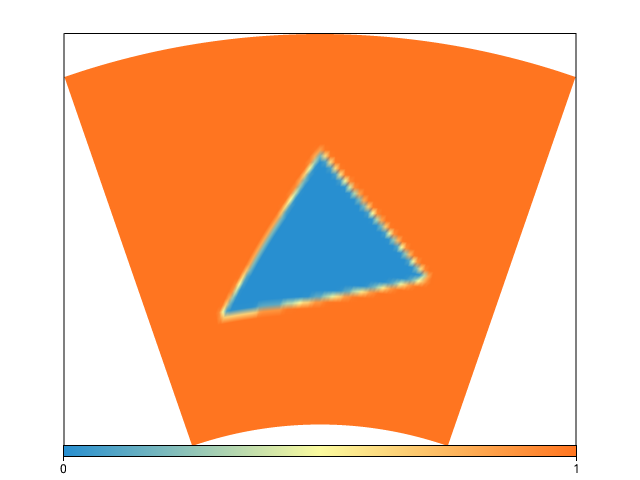

In [66]:
quickShow(anFunc)

In [71]:
fn.branching.conditional([
    (system.temperatureField > 0.5, True),
    (True, False)
    ]).evaluate(system.mesh)

array([[ True],
       [ True],
       [ True],
       ..., 
       [False],
       [False],
       [False]], dtype=bool)